# Problem 1

Consider a 2D robotic arm with 3 links. The position of its end-effector is governed by the arm lengths and joint angles as follows (as in the figure "data/robot-arm.png"):
$$
x = L_1 \cos(\theta_1) + L_2\cos(\theta_2+\theta_1) + L_3\cos(\theta_3+\theta_2+\theta_1)\\
y = L_1\sin(\theta_1) + L_2\sin(\theta_2+\theta_1) + L_3\sin(\theta_3+\theta_2+\theta_1)
$$

In robotics settings, inverse-kinematics problems are common for setups like this. For example, suppose all 3 arm lengths are $L_1 = L_2 = L_3 = 1$, and we want to position the end-effector at $(x,y) = (0.5, 0.5)$. What set of joint angles $(\theta_1, \theta_2, \theta_3)$ should we choose for the end-effector to reach this position?

In this problem you will train a neural network to find a function mapping from coordinates $(x,y)$ to joint angles $(\theta_1, \theta_2, \theta_3)$ that position the end-effector at $(x,y)$.



#### Summary of deliverables:

1. Neural network model

2. Generate training and validation data

3. Training function

4. 6 plots with training and validation loss

5. 6 prediction plots

6. Respond to the prompts


In [10]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim

class ForwardArm(nn.Module):
    def __init__(self, L1=1, L2=1, L3=1):
        super().__init__()
        self.L1 = L1
        self.L2 = L2
        self.L3 = L3
    def forward(self, angles):
        theta1 = angles[:,0]
        theta2 = angles[:,1]
        theta3 = angles[:,2]
        x = self.L1*torch.cos(theta1) + self.L2*torch.cos(theta1+theta2) + self.L3*torch.cos(theta1+theta2+theta3)
        y = self.L1*torch.sin(theta1) + self.L2*torch.sin(theta1+theta2) + self.L3*torch.sin(theta1+theta2+theta3)
        return torch.vstack([x,y]).T

def plot_predictions(model, title=""):
    fwd = ForwardArm()

    vals = np.arange(0.1, 2.0, 0.2)
    x, y = np.meshgrid(vals,vals)
    coords = torch.tensor(np.vstack([x.flatten(),y.flatten()]).T,dtype=torch.float)
    angles = model(coords)
    preds = fwd(angles).detach().numpy()

    plt.figure(figsize=[4,4],dpi=140)

    plt.scatter(x.flatten(), y.flatten(), s=60, c="None",marker="o",edgecolors="k", label="Targets")
    plt.scatter(preds[:,0], preds[:,1], s=25, c="red", marker="o", label="Predictions")
    plt.text(0.1, 2.15, f"MSE = {nn.MSELoss()(fwd(model(coords)),coords):.1e}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(-.1,2.1)
    plt.ylim(-.1,2.4)
    plt.legend()
    plt.title(title)
    plt.show()

def plot_arm(theta1, theta2, theta3, L1=1,L2=1,L3=1, show=True):
    x1 = L1*np.cos(theta1)
    y1 = L1*np.sin(theta1)
    x2 = x1 + L2*np.cos(theta1+theta2)
    y2 = y1 + L2*np.sin(theta1+theta2)
    x3 = x2 + L3*np.cos(theta1+theta2+theta3)
    y3 = y2 + L3*np.sin(theta1+theta2+theta3)
    xs = np.array([0,x1,x2,x3])
    ys = np.array([0,y1,y2,y3])

    plt.figure(figsize=(5,5),dpi=140)
    plt.plot(xs, ys, linewidth=3, markersize=5,color="gray", markerfacecolor="lightgray",marker="o",markeredgecolor="black")
    plt.scatter(x3,y3,s=50,color="blue",marker="P",zorder=100)
    plt.scatter(0,0,s=50,color="black",marker="s",zorder=-100)
    
    plt.xlim(-1.5,3.5)
    plt.ylim(-1.5,3.5)

    if show:
        plt.show()

## End-effector position

You can use the interactive figure below to visualize the robot arm.

In [11]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual, Layout, FloatSlider, Dropdown

def plot_unit_arm(theta1, theta2, theta3):
    plot_arm(theta1, theta2, theta3)

slider1 = FloatSlider(value=0, min=-np.pi*0.75, max=np.pi*0.75, step=np.pi/100, description='theta1',disabled=False,continuous_update=True,orientation='horizontal',readout=False,layout = Layout(width='550px'))
slider2 = FloatSlider(value=0, min=-np.pi*0.75, max=np.pi*0.75, step=np.pi/100, description='theta2',disabled=False,continuous_update=True,orientation='horizontal',readout=False,layout = Layout(width='550px'))
slider3 = FloatSlider(value=0, min=-np.pi*0.75, max=np.pi*0.75, step=np.pi/100, description='theta3',disabled=False,continuous_update=True,orientation='horizontal',readout=False,layout = Layout(width='550px'))

interactive_plot = interactive(plot_unit_arm, theta1 = slider1, theta2 = slider2, theta3 = slider3)
output = interactive_plot.children[-1]
output.layout.height = '600px'

interactive_plot

interactive(children=(FloatSlider(value=0.0, description='theta1', layout=Layout(width='550px'), max=2.3561944…

## Neural Network for Inverse Kinematics
In this class we have mainly had regression problems with only one output. However, you can create neural networks with any number of outputs just by changing the size of the last layer. For this problem, we already know the function to go from joint angles (3) to end-effector coordinates (2). This is provided in neural network format as `ForwardArm()`.

If you provide an instance of `ForwardArm()` with an $N\times3$ tensor of joint angles, and it will return an $N\times2$ tensor of coordinates.

Here, you should create a neural network with 2 inputs and 3 outputs that, once trained, can output the joint angles (in radians) necessary to reach the input x-y coordinates.

In the cell below, complete the definition for `InverseArm()`:
- The initialization argument `hidden_layer_sizes` dictates the number of neurons per hidden layer in the network. For example, `hidden_layer_sizes=[12,24]` should create a network with 2 inputs, 12 neurons in the first hidden layer, 24 neurons in the second hidden layer, and 3 outputs.
- Use a ReLU activation at the end of each hidden layer.
- The initialization argument `max_angle` refers to the maximum bend angle of the joint. If `max_angle=None`, there should be no activation at the last layer. However, if `max_angle=1` (for example), then the output joint angles should be restricted to the interval [-1, 1] (radians). You can clamp values with the tanh function (and then scale them) to achieve this.



In [93]:
class InverseArm(nn.Module):
    def __init__(self, hidden_layer_sizes=[24,24], max_angle=None):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(2,hidden_layer_sizes[0]),
        )
        for i in range(0,len(hidden_layer_sizes)-1):
            self.seq.append(nn.ReLU())
            self.seq.append(nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i+1]))
        self.seq.append(nn.ReLU())
        self.seq.append(nn.Linear(hidden_layer_sizes[-1], 3))
        self.max_angle = max_angle
        if max_angle is not None:
            self.seq.append(nn.Tanh())

    def forward(self, xy):
        if self.max_angle is not None:
            return self.seq(xy) * self.max_angle
        return self.seq(xy)

## Generate Data

In the cell below, generate a dataset of x-y coordinates. You should use a $100\times 100$ meshgrid, for x and y each on the interval $[0, 2]$.  

Randomly split your data so that 80% of points are in `X_train`, while the remaining 20% are in `X_val`. (Each of these should have 2 columns -- x and y)

In [85]:
x,y = np.meshgrid(np.linspace(0,2,100),np.linspace(0,2,100))
x = x.reshape(-1,1)
y = y.reshape(-1,1)
N = x.shape[0]
idx = np.random.permutation(N)
X = np.concatenate([x,y], axis=1)
X_train = torch.Tensor(X[idx[:int(N*0.8)]])
X_val = torch.Tensor(X[idx[int(N*0.8):]])
print(f"X_train Size: {X_train.shape[0]}\t X_val Size: {X_val.shape[0]}")

X_train Size: 8000	 X_val Size: 2000


## Training function

Write a function `train()` below with the following specifications:

*Inputs:*  
- `model`: `InverseArm` model to train
- `X_train`: $N\times 2$ vector of training x-y coordinates
- `X_val`: $N\times 2$ vector of validation x-y coordinates
- `lr`: Learning rate for Adam optimizer
- `epochs`: Total epoch count
- `gamma`: ExponentialLR decay rate
- `create_plot`: (`True`/`False`) Whether to display a plot with training and validation loss curves

*Loss function:*  
The loss function you use should be based on whether the end-effector moves to the correct location. It should be the MSE between the target coordinate tensor and the coordinates that the predicted joint angles produce. In other words, if your inverse kinematics model is `model`, and `fwd` is an instance of `ForwardArm()`, then you want the MSE between input coordinates `X` and `fwd(model(X))`.


In [95]:
def plot_loss(train_loss, val_loss):
    plt.figure(figsize=(4,2),dpi=250)
    plt.plot(train_loss,label="Training")
    plt.plot(val_loss,label="Validation",linewidth=1)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

def train(model, X_train, X_val, lr = 0.01, epochs = 1000, gamma = 1, create_plot = True):

    train_hist = []
    val_hist = []

    fwd_arm = ForwardArm()

    opt = optim.Adam(params = model.parameters(), lr=lr, weight_decay=gamma)

    for epoch in range(epochs):
        model.train()
        fwd = fwd_arm.forward(model(X_train))
        loss_train = ((fwd[:,0] - X_train[:,0])**2).sum() + ((fwd[:,1] - X_train[:,1])**2).sum()
        train_hist.append(loss_train.item())

        model.eval()
        fwd = fwd_arm.forward(model(X_val))
        loss_val = ((fwd[:,0] - X_val[:,0])**2).sum() + ((fwd[:,1] - X_val[:,1])**2).sum()
        val_hist.append(loss_val.item())

        opt.zero_grad()
        loss_train.backward()
        opt.step()

        if epoch % int(epochs / 25) == 0:
            print(f"Epoch {epoch:>4} of {epochs}:   Train Loss = {loss_train.item():.4f}   Validation Loss = {loss_val.item():.4f}")
    if (create_plot):
        plot_loss(train_hist, val_hist)
    return

## Training a model

Create 3 models of different complexities (with `max_angle=None`):
- `hidden_layer_sizes=[12]`
- `hidden_layer_sizes=[24,24]`
- `hidden_layer_sizes=[48,48,48]`

Train each model for 1000 epochs, learning rate 0.01, and gamma 0.995. Show the plot for each.

Epoch    0 of 1000:   Train Loss = 25546.5645   Validation Loss = 6280.7920
Epoch   40 of 1000:   Train Loss = 5233.4805   Validation Loss = 1312.8132
Epoch   80 of 1000:   Train Loss = 603.5000   Validation Loss = 152.6647
Epoch  120 of 1000:   Train Loss = 193.5890   Validation Loss = 47.6573
Epoch  160 of 1000:   Train Loss = 41.4407   Validation Loss = 10.0890
Epoch  200 of 1000:   Train Loss = 28.9926   Validation Loss = 7.2588
Epoch  240 of 1000:   Train Loss = 24.0554   Validation Loss = 5.9660
Epoch  280 of 1000:   Train Loss = 20.0644   Validation Loss = 4.9348
Epoch  320 of 1000:   Train Loss = 17.6081   Validation Loss = 4.3392
Epoch  360 of 1000:   Train Loss = 16.4072   Validation Loss = 4.0608
Epoch  400 of 1000:   Train Loss = 15.1366   Validation Loss = 3.7793
Epoch  440 of 1000:   Train Loss = 14.1027   Validation Loss = 3.5733
Epoch  480 of 1000:   Train Loss = 13.3510   Validation Loss = 3.3931
Epoch  520 of 1000:   Train Loss = 12.7572   Validation Loss = 3.2550
Epo

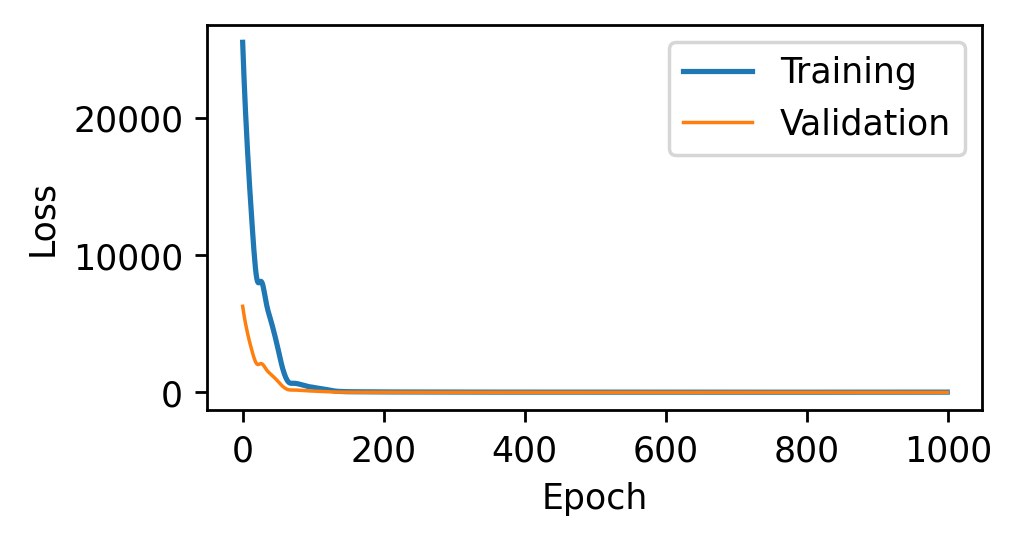

Epoch    0 of 1000:   Train Loss = 34373.7578   Validation Loss = 8594.2656
Epoch   40 of 1000:   Train Loss = 755.1193   Validation Loss = 194.0777
Epoch   80 of 1000:   Train Loss = 67.2362   Validation Loss = 18.2116
Epoch  120 of 1000:   Train Loss = 18.7699   Validation Loss = 4.7104
Epoch  160 of 1000:   Train Loss = 10.9724   Validation Loss = 2.8248
Epoch  200 of 1000:   Train Loss = 8.8017   Validation Loss = 2.2716
Epoch  240 of 1000:   Train Loss = 5.7757   Validation Loss = 1.4593
Epoch  280 of 1000:   Train Loss = 5.0449   Validation Loss = 1.3011
Epoch  320 of 1000:   Train Loss = 4.6540   Validation Loss = 1.2005
Epoch  360 of 1000:   Train Loss = 3.9765   Validation Loss = 1.0749
Epoch  400 of 1000:   Train Loss = 3.4201   Validation Loss = 0.9314
Epoch  440 of 1000:   Train Loss = 3.2506   Validation Loss = 0.8940
Epoch  480 of 1000:   Train Loss = 3.0020   Validation Loss = 0.8251
Epoch  520 of 1000:   Train Loss = 2.8602   Validation Loss = 0.7898
Epoch  560 of 1000:

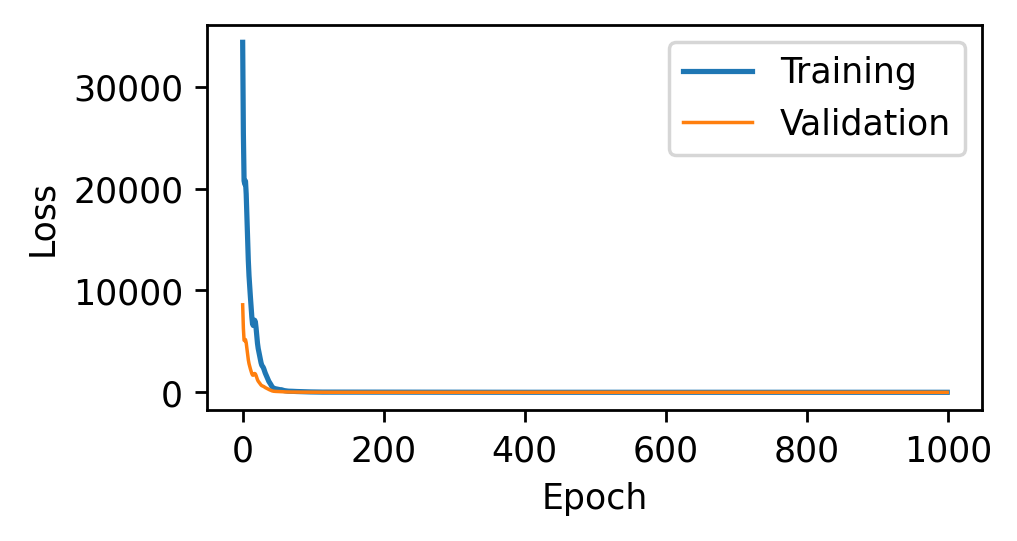

Epoch    0 of 1000:   Train Loss = 44264.2422   Validation Loss = 11154.2012
Epoch   40 of 1000:   Train Loss = 366.9883   Validation Loss = 90.7924
Epoch   80 of 1000:   Train Loss = 27.2176   Validation Loss = 7.3276
Epoch  120 of 1000:   Train Loss = 9.8337   Validation Loss = 2.5741
Epoch  160 of 1000:   Train Loss = 6.0183   Validation Loss = 1.6150
Epoch  200 of 1000:   Train Loss = 4.6248   Validation Loss = 1.2447
Epoch  240 of 1000:   Train Loss = 3.8746   Validation Loss = 1.0435
Epoch  280 of 1000:   Train Loss = 3.3499   Validation Loss = 0.9101
Epoch  320 of 1000:   Train Loss = 2.8528   Validation Loss = 0.7708
Epoch  360 of 1000:   Train Loss = 3.8809   Validation Loss = 0.9941
Epoch  400 of 1000:   Train Loss = 3.0453   Validation Loss = 0.7888
Epoch  440 of 1000:   Train Loss = 2.1278   Validation Loss = 0.5720
Epoch  480 of 1000:   Train Loss = 1.9743   Validation Loss = 0.5302
Epoch  520 of 1000:   Train Loss = 2.1048   Validation Loss = 0.5699
Epoch  560 of 1000:   

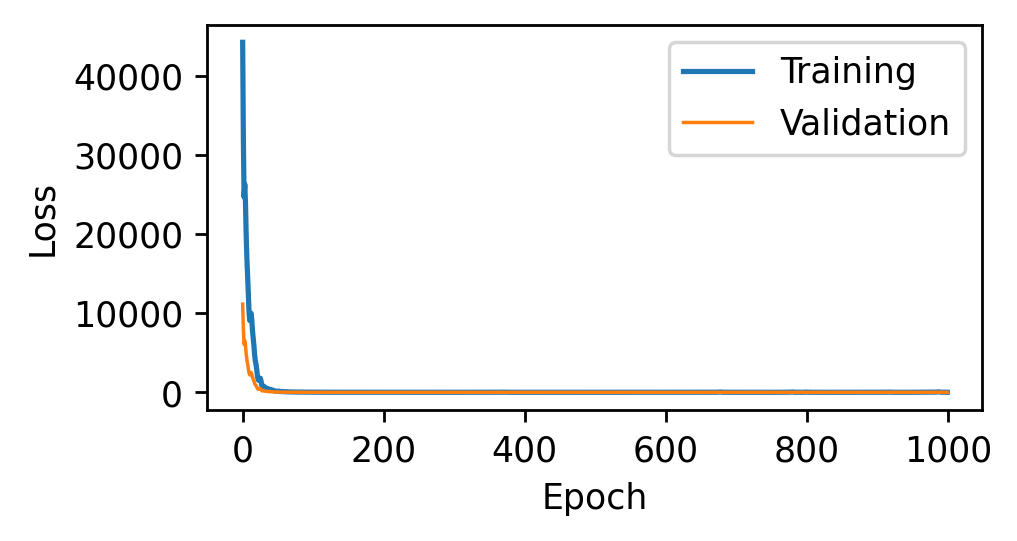

In [96]:
model1 = InverseArm(hidden_layer_sizes=[12], max_angle=None)
model2 = InverseArm(hidden_layer_sizes=[24,24], max_angle=None)
model3 = InverseArm(hidden_layer_sizes=[48,48,48], max_angle=None)

train(model1, X_train, X_val, lr=0.01, epochs=1000, gamma=0.995, create_plot=True)
train(model2, X_train, X_val, lr=0.01, epochs=1000, gamma=0.995, create_plot=True)
train(model3, X_train, X_val, lr=0.01, epochs=1000, gamma=0.995, create_plot=True)

## Visualizations

For each of your models, use the function `plot_predictions` to visualize model predictions on the domain. You should observe improvements with increasing network size.

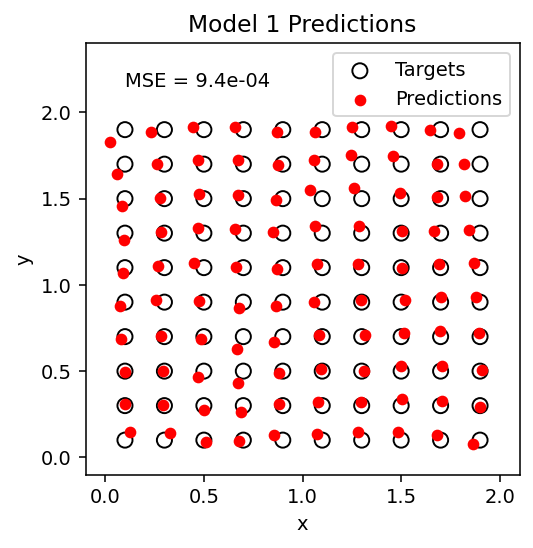

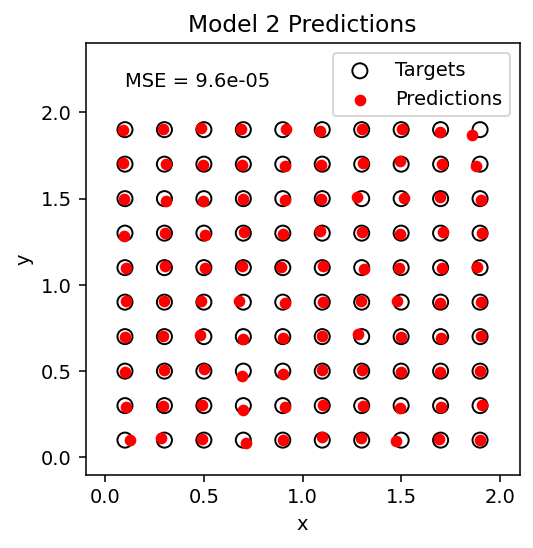

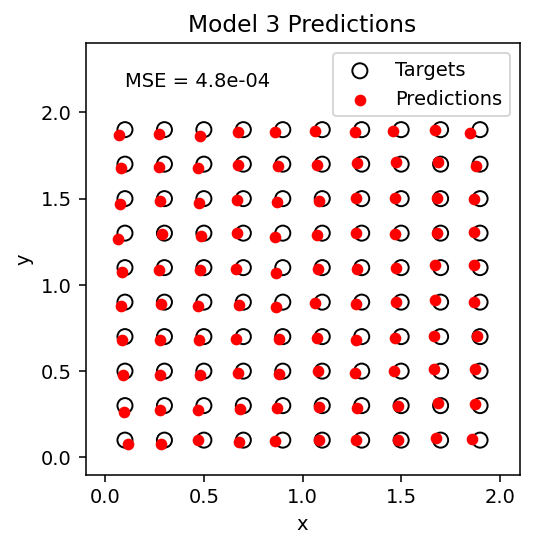

In [97]:
plot_predictions(model1, "Model 1 Predictions")
plot_predictions(model2, "Model 2 Predictions")
plot_predictions(model3, "Model 3 Predictions")

## Interactive Visualization


You can use the interactive plot below to look at the performance of your model. (The model used must be named `model`.)

In [98]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual, Layout, FloatSlider, Dropdown
model = model1
def plot_inverse(x, y):
    xy = torch.Tensor([[x,y]])
    theta1, theta2, theta3 = model(xy).detach().numpy().flatten().tolist()
    plot_arm(theta1, theta2, theta3, show=False)
    plt.scatter(x, y, s=100, c="red",zorder=1000,marker="x")
    plt.plot([0,2,2,0,0],[0,0,2,2,0],c="lightgray",linewidth=1,zorder=-1000)
    plt.show()

slider1 = FloatSlider(value=1, min=-.5, max=2.5, step=1/100, description='x', disabled=False, continuous_update=True, orientation='horizontal', readout=False, layout = Layout(width='550px'))
slider2 = FloatSlider(value=1, min=-.5, max=2.5, step=1/100, description='y', disabled=False, continuous_update=True, orientation='horizontal', readout=False, layout = Layout(width='550px'))

interactive_plot = interactive(plot_inverse, x = slider1, y = slider2)
output = interactive_plot.children[-1]
output.layout.height = '600px'

interactive_plot

interactive(children=(FloatSlider(value=1.0, description='x', layout=Layout(width='550px'), max=2.5, min=-0.5,…

## Training more neural networks

Now train more networks with the following details:
1. `hidden_layer_sizes=[48,48], max_angle=torch.pi/2`, train with `lr=0.01, epochs=1000, gamma=.995`
2. `hidden_layer_sizes=[48,48], max_angle=None`, train with `lr=1, epochs=1000, gamma=1`
3. `hidden_layer_sizes=[48,48], max_angle=2`, train with `lr=0.0001, epochs=300, gamma=1`

For each network, show a loss curve plot and a `plot_predictions` plot.

Epoch    0 of 1000:   Train Loss = 80679.2109   Validation Loss = 20523.1016
Epoch   40 of 1000:   Train Loss = 1183.4551   Validation Loss = 298.9445
Epoch   80 of 1000:   Train Loss = 431.3502   Validation Loss = 109.6607
Epoch  120 of 1000:   Train Loss = 329.2130   Validation Loss = 85.4530
Epoch  160 of 1000:   Train Loss = 304.8269   Validation Loss = 79.3076
Epoch  200 of 1000:   Train Loss = 296.8060   Validation Loss = 77.4190
Epoch  240 of 1000:   Train Loss = 291.0080   Validation Loss = 76.0475
Epoch  280 of 1000:   Train Loss = 288.3641   Validation Loss = 75.4505
Epoch  320 of 1000:   Train Loss = 285.7700   Validation Loss = 74.8172
Epoch  360 of 1000:   Train Loss = 283.8395   Validation Loss = 74.3492
Epoch  400 of 1000:   Train Loss = 282.3068   Validation Loss = 73.9939
Epoch  440 of 1000:   Train Loss = 282.1997   Validation Loss = 73.9915
Epoch  480 of 1000:   Train Loss = 284.5198   Validation Loss = 74.5711
Epoch  520 of 1000:   Train Loss = 287.7758   Validation

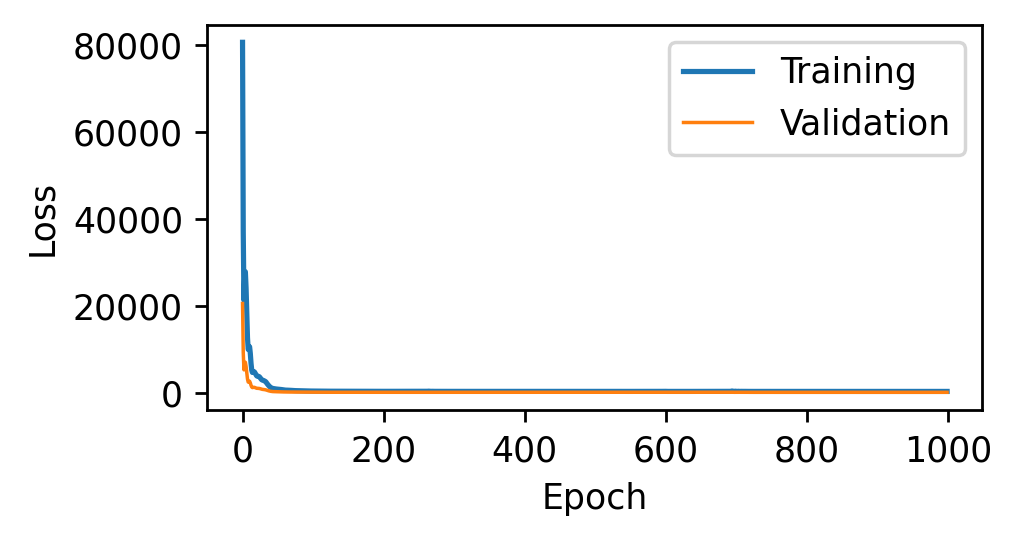

Epoch    0 of 1000:   Train Loss = 41916.7227   Validation Loss = 10490.3389
Epoch   40 of 1000:   Train Loss = 5580.8760   Validation Loss = 1397.8684
Epoch   80 of 1000:   Train Loss = 27271.2773   Validation Loss = 7010.5996
Epoch  120 of 1000:   Train Loss = 5842.3164   Validation Loss = 1504.8444
Epoch  160 of 1000:   Train Loss = 7810.2197   Validation Loss = 1995.0405
Epoch  200 of 1000:   Train Loss = 34657.6406   Validation Loss = 8775.2568
Epoch  240 of 1000:   Train Loss = 5697.0640   Validation Loss = 1463.8599
Epoch  280 of 1000:   Train Loss = 5428.1333   Validation Loss = 1376.9443
Epoch  320 of 1000:   Train Loss = 5425.9106   Validation Loss = 1375.6538
Epoch  360 of 1000:   Train Loss = 5425.9038   Validation Loss = 1375.7328
Epoch  400 of 1000:   Train Loss = 5425.9043   Validation Loss = 1375.7371
Epoch  440 of 1000:   Train Loss = 5425.9043   Validation Loss = 1375.7346
Epoch  480 of 1000:   Train Loss = 5425.9048   Validation Loss = 1375.7485
Epoch  520 of 1000:  

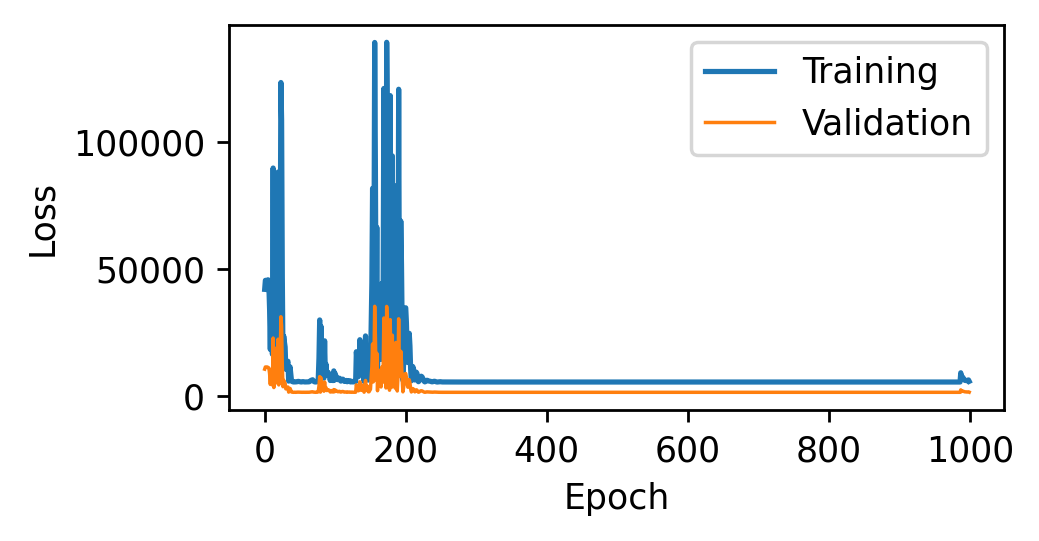

Epoch    0 of 300:   Train Loss = 67431.0859   Validation Loss = 17155.5176
Epoch   12 of 300:   Train Loss = 56133.7344   Validation Loss = 14233.1855
Epoch   24 of 300:   Train Loss = 45643.7852   Validation Loss = 11515.0762
Epoch   36 of 300:   Train Loss = 36858.4531   Validation Loss = 9237.4844
Epoch   48 of 300:   Train Loss = 30263.4727   Validation Loss = 7528.7607
Epoch   60 of 300:   Train Loss = 25845.8203   Validation Loss = 6386.8262
Epoch   72 of 300:   Train Loss = 23225.0059   Validation Loss = 5712.7666
Epoch   84 of 300:   Train Loss = 21776.6562   Validation Loss = 5343.5337
Epoch   96 of 300:   Train Loss = 20943.3418   Validation Loss = 5135.2290
Epoch  108 of 300:   Train Loss = 20370.2148   Validation Loss = 4994.2476
Epoch  120 of 300:   Train Loss = 19871.3066   Validation Loss = 4871.4351
Epoch  132 of 300:   Train Loss = 19369.9844   Validation Loss = 4747.1338
Epoch  144 of 300:   Train Loss = 18837.3984   Validation Loss = 4615.2271
Epoch  156 of 300:   T

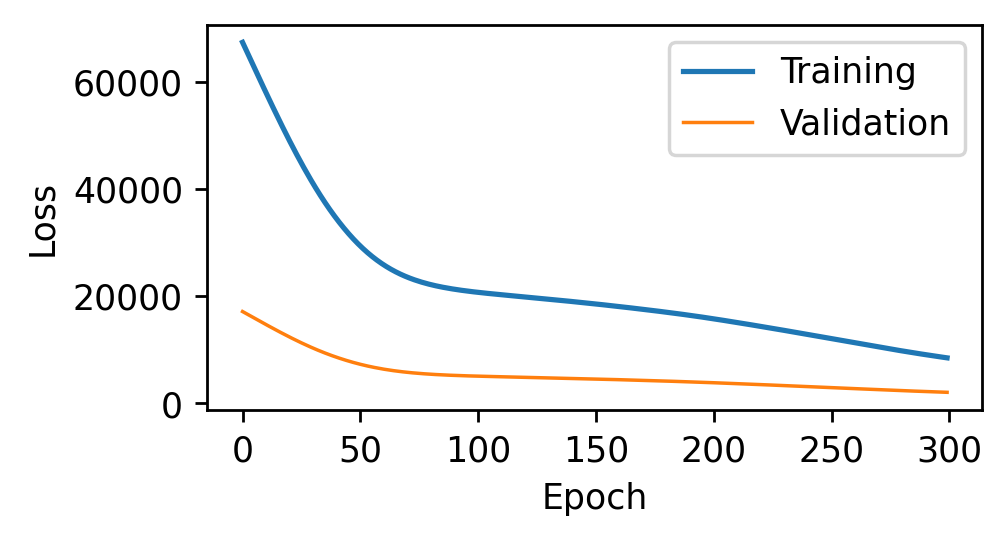

In [99]:
model1 = InverseArm(hidden_layer_sizes=[48,48], max_angle=torch.pi/2)
model2 = InverseArm(hidden_layer_sizes=[48,48], max_angle=None)
model3 = InverseArm(hidden_layer_sizes=[48,48], max_angle=2)

train(model1, X_train, X_val, lr=0.01, epochs=1000, gamma=0.995, create_plot=True)
train(model2, X_train, X_val, lr=1, epochs=1000, gamma=1, create_plot=True)
train(model3, X_train, X_val, lr=0.0001, epochs=300, gamma=1, create_plot=True)

## Prompts

Neither of these models should have great performance.
Describe what went wrong in each case.

In the first case, the model wasn't allowed to predict across the whole range of joint angles needed to reach each configuration.

In the second case, the model had too large of a learning rate leading to the noisy training and validation loss.

In the third case, the learning rate was too low with not enough epochs thus the model didn't have enough time to fully train to the data.